In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
import matplotlib.pyplot as pyplot 

In [2]:
src= cv.imread("./src.jpg")
print("原始图像尺寸：{}".format(src.shape))

原始图像尺寸：(128, 128, 3)


In [3]:
kernel=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
print(kernel)

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


In [4]:
import time

start_time = time.time()
dst = cv.filter2D(src, -1, kernel)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.06167483329772949s


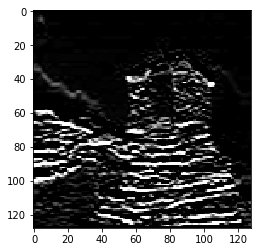

In [5]:
plt.imshow(dst[:, :, ::-1])

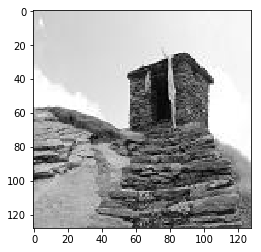

In [6]:
plt.imshow(src[:, :, ::-1])

In [7]:
from pynq import Overlay
overlay = Overlay("./design_1.bit")
tool = overlay.filter2d_accel_0

In [8]:
rows = 128
cols = 128

这部分进行内存分配 ， Xlnk为低版本操作，allocate为高版本

In [9]:
from pynq import Xlnk
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(128*128,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(126*126,), dtype=np.int32)
kernel_buffer=xlnk.cma_array(shape=(3*3,),dtype=np.int32)
print("Buffer pointer address (physical memory):")
print(hex(in_buffer.physical_address))

Buffer pointer address (physical memory):
0x18050000


In [10]:
from pynq import allocate
in_buffer = allocate(shape=(rows*cols,), dtype='u1')
out_buffer = allocate(shape=(rows*cols,), dtype='u1')
kernel_buffer=xlnk.cma_array(shape=(3*3,),dtype='u1')

ImportError: cannot import name 'allocate'

In [11]:
img_in = [[0]for i in range(0,16384)]
img_out = [[0]for i in range(0,15876)]
for i in range(0,128):
    for j in range(0,128):
        img_in[i*128+j]=src[i][j][0]
for i in range(0,126):
    for j in range(0,126):
        img_out[i*126+j]=0
kernel_size = [-1,-2,-1,0,0,0,1,2,1]

In [12]:
np.copyto(in_buffer, np.int32(img_in))
np.copyto(out_buffer, np.int32(img_out))
np.copyto(kernel_buffer, np.int32(kernel_size))

In [13]:
tool.s_axi_control.write(0x10,in_buffer.physical_address)
tool.s_axi_control.write(0x1c,kernel_buffer.physical_address)
tool.s_axi_control.write(0x28,out_buffer.physical_address)
tool.s_axi_CTRL.write(0x10, rows)
tool.s_axi_CTRL.write(0x18, cols)

In [15]:
import time

tool.s_axi_CTRL.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = tool.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.03945207595825195s


In [16]:
out_buffer.shape

(15876,)

In [19]:
print(out_buffer[15875])

106


In [22]:
f =open("./1.txt",'w')
for i in range(0,15876):
    f.write(str(out_buffer[i])+'\n')
f.close()

In [21]:
f=open("./2.txt",'w')
for i in range(14385,15876):
    f.write(str(out_buffer[i])+'\n')

In [ ]:
dst[0][2][0]